
# Description

This notebook explores the effect of "overfitting" data splitting on subsequent treatment effect estimates.

# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from linearmodels.iv import IV2SLS

# Common issue with glibc, scikit (?), where the number of libraries loaded with static TLS is limited
# Can only load one of econml or rpy2...
# e.g. https://github.com/pytorch/pytorch/issues/2575#issuecomment-523657178
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

import sys

# user imports
sys.path.append("../")

# Don't import iv_power for now since it needs rpy2
from utils.pwr import rdd_power #, iv_power

## Matplotlib setup

In [2]:
# matplotlib config
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

## RPy2 setup

In [3]:
#Import necessary packages
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# #Must be activated
# pandas2ri.activate()

# Simulation data functions

In [4]:
def create_covariates(n_samples, seed=0, **kwargs):
    """
    Generates a covariate matrix of the given number of samples and features.
    
    Args:
        n_samples (int): number of samples to generate
        seed (int): seed for reproducibility
        **kwargs (dict): other keyword arguments passed to make_regression
    
    Returns:
        pd.DataFrame
    """
    #print(kwargs)
    
    X, y = make_regression(n_samples=n_samples, random_state=seed, **kwargs)
    
    feat_cols = ["feat_" + str(x) for x in range(X.shape[1])]
    
    df = pd.DataFrame(X, columns=feat_cols)
    
    # min max scale to [0, 1]
    # change 0 to -1 to scale to [-1, 1]
    rescale_y = 0 + ((y - np.min(y))*(1 - (0)) / (np.max(y) - np.min(y)))
    
    df['comply_coeff'] = rescale_y

    return df

In [5]:
def generate_IV_comply_indicator(n_samples, tau, seed=0, 
                                 prop_nt=0.4, prop_at=0.4, prop_z=0.5, 
                                 C_T=0.8, Z_T=0.8,
                                 use_covars=False,
                                 regression_dict={}):
    """
    Generates IV data with perfect compliance indicator X.
    
    Note from Baocchi et al. 2014 Eq 16 that "instrument strength" is equivalent to proportion of compliers.
    
    
    See this for simulating IVs:
        - https://statmodeling.stat.columbia.edu/2019/06/20/how-to-simulate-an-instrumental-variables-problem/
    
    Args:
        n_samples (int): the number of samples to generate
        tau (float): the treatment effect on compliers to measure
        seed (int): see for reproducibility
        prop_nt (float): the proportion of never takers
        prop_at (float): the proportion of always takers, note that prop_comply is then 1 - prop_nt - prop_at
        prop_z (float): the proportion of individuals "encouraged" by the instrument
        C_T (float): the covariance between the confounder and treatment; only applies to compliers 
                     TODO is this an issue?
        Z_T (float): the covariance between the instrument and treatment
        use_covars (bool): whether or not to generate covariates that determine compliance
        regression_dict (dict): kwargs to pass to sklearn.make_regression, only used when use_covars=True
        
    Returns:
        feat_df (pd.DataFrame): dataframe containing all columns for IV analysis
    """
    assert (prop_nt + prop_at) < 1, "proportion of compliers needs to be > 0"
    
    
    
    if use_covars:
        feat_df = create_covariates(n_samples=n_samples, seed=seed, **regression_dict)

        loc, scale = norm.fit(feat_df['comply_coeff'])
        
        def comply_indicator(x):
            if x < norm.ppf(prop_nt, loc=loc, scale=scale):
                return 'nt'
            elif x < norm.ppf(prop_nt + prop_at, loc=loc, scale=scale):
                return 'at'
            else:
                return 'co'
    else:
        np.random.seed(seed)
        feat_df = pd.DataFrame()
        feat_df['comply_coeff'] = np.random.uniform(0, 1, size=n_samples)

        def comply_indicator(x):
            if x < prop_nt:
                return 'nt'
            elif x < prop_nt + prop_at:
                return 'at'
            else:
                return 'co'

    feat_df['comply_status'] = feat_df['comply_coeff'].apply(comply_indicator)
    X = (feat_df['comply_status'] == 'co').astype(int)
    
    # vars:             Z    T    C
    covar = np.array([[1.0, Z_T, 0.0], # Z
                      [Z_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    
    covar += np.eye(3,3)

    # vars:  Z  T  C
    means = [0, 0, 0]

    # generate Z, T, Z
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)
    
    # generate binary instrument
    Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)
    
    # generate endogenous treatment
    T = (data[:, 1] > 0).astype(int)

    # fill in Z when the sample is a complier, 0 for nt, 1 for at
    T = np.where(feat_df['comply_status'] == 'co', Z, T)
    T = np.where(feat_df['comply_status'] == 'nt', 0, T)
    T = np.where(feat_df['comply_status'] == 'at', 1, T)
    
    C = data[:, 2]
    
    # add noncomplier bias, currently symmetric for never-takers and always-takers
    nc_bias_eff = 0.25
    B = np.where(X != 1, nc_bias_eff, 0)
    
    #Y = (tau + B)*T + C + np.random.normal(0, 1, n_samples)
    
    # optionally add heteroskedastic noise
    Y = (tau + B)*T + C + np.random.normal(0, 1, n_samples) + ((1-X) * np.random.normal(0, 1, n_samples))
    
    feat_df['Z'] = Z
    feat_df['X'] = X
    feat_df['T'] = T
    feat_df['C'] = C
    feat_df['Y'] = Y
    feat_df['B'] = B
    
    return feat_df

In [6]:
formula = 'Y ~ 1 + [T ~ Z]'

def simulation(n, tau, prop_comply, n_trials, exclude_criteria=None, confound_str=0.8):
    pwrs = []
    tau_hats = []
    n_excluded = []
    var_hats = []
    
    for trial in range(n_trials):
        prop_nt = (1 - prop_comply) / 2
        prop_at = (1 - prop_comply) / 2
        #df = generate_IV(n, tau, prop_comply, trial, confound_str)
        df = generate_IV_comply_indicator(n, tau, 
                                          prop_nt=prop_nt, prop_at=prop_at, 
                                          seed=trial, C_T=confound_str)
        
        if exclude_criteria == "TneqZ":
            sel_df = df[df['T'] == df['Z']]
        elif exclude_criteria == "comply":
            sel_df = df[df['X'] == 1]
        elif exclude_criteria is None:
            sel_df = df
            
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')
        var = iv_results.std_errors['T']**2
        tau_hat = iv_results.params['T']
        
        pwr = rdd_power(tau, var)
        pwrs.append(pwr)
        tau_hats.append(tau_hat)
        var_hats.append(var)
        
        n_excluded.append(df.shape[0] - sel_df.shape[0])

    return tau_hats, pwrs, var_hats, n_excluded

In [7]:
def plot_results(tau, tau_hats, pwrs, var_hats, n_exclude):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), dpi=150)
    sns.boxplot(data=tau_hats, ax=ax1, orient='h')
    ax1.axvline(tau, color='black', ls='--', label="true treatment effect", )
    ax1.set_xlim(tau - 1.5, tau + 1.5)
    ax1.legend()
    ax1.set_ylabel("Est. treatment effect")

    sns.boxplot(data=pwrs, color='green', ax=ax2, orient='h')
    ax2.set_xlim(0, 1)
    ax2.set_ylabel("Est. power")
    
    
    sns.boxplot(data=var_hats, color='red', ax=ax3, orient='h')
    ax3.set_xlim(0, 0.5)
    ax3.set_ylabel("Std. errors")

    
    sns.boxplot(data=n_exclude, color='orange', ax=ax4, orient='h')
    #ax2.set_xlim(0, 1)
    ax4.set_ylabel("Num excluded")

## Single-run test

In [8]:
n_samples = 1000
prop_comply = 0.5
tau = 0.5
seed = 42

# by default, set prop_nt = prop_at
prop_nt = (1 - prop_comply) / 2
prop_at = (1 - prop_comply) / 2


iv_df = generate_IV_comply_indicator(n_samples, tau, seed=seed, prop_at=prop_at, prop_nt=prop_nt)

formula = 'Y ~ 1 + [T ~ Z]'
iv_model = IV2SLS.from_formula(formula, iv_df)
iv_results = iv_model.fit(cov_type='robust')

In [9]:
display(iv_results)
var = iv_results.std_errors['T']**2
print("rdd_power() calculation: {:.3f}".format(rdd_power(tau, var)))
#print("iv_power() calculation: {:.3f}".format(iv_power(iv_df, tau, robust_se=False)))

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0080
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0070
No. Observations:                1000   F-statistic:                    1.7801
Date:                Fri, Oct 22 2021   P-value (F-stat)                0.1821
Time:                        13:14:16   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0573     0.1125     0.5091     0.6107     -0.1633      0.2778
T              0.2826     0.2118     1.3342     0.1821     -0.1326      0.6978
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f394c9e1c90

rdd_power() calculation: 0.656


## Simulation sandbox

In [10]:
n = 500
n_trials = 500
prop_comply = 0.5
tau = 0.5

0.6274959517518255
CPU times: user 1min 17s, sys: 2.08 s, total: 1min 19s
Wall time: 9.99 s


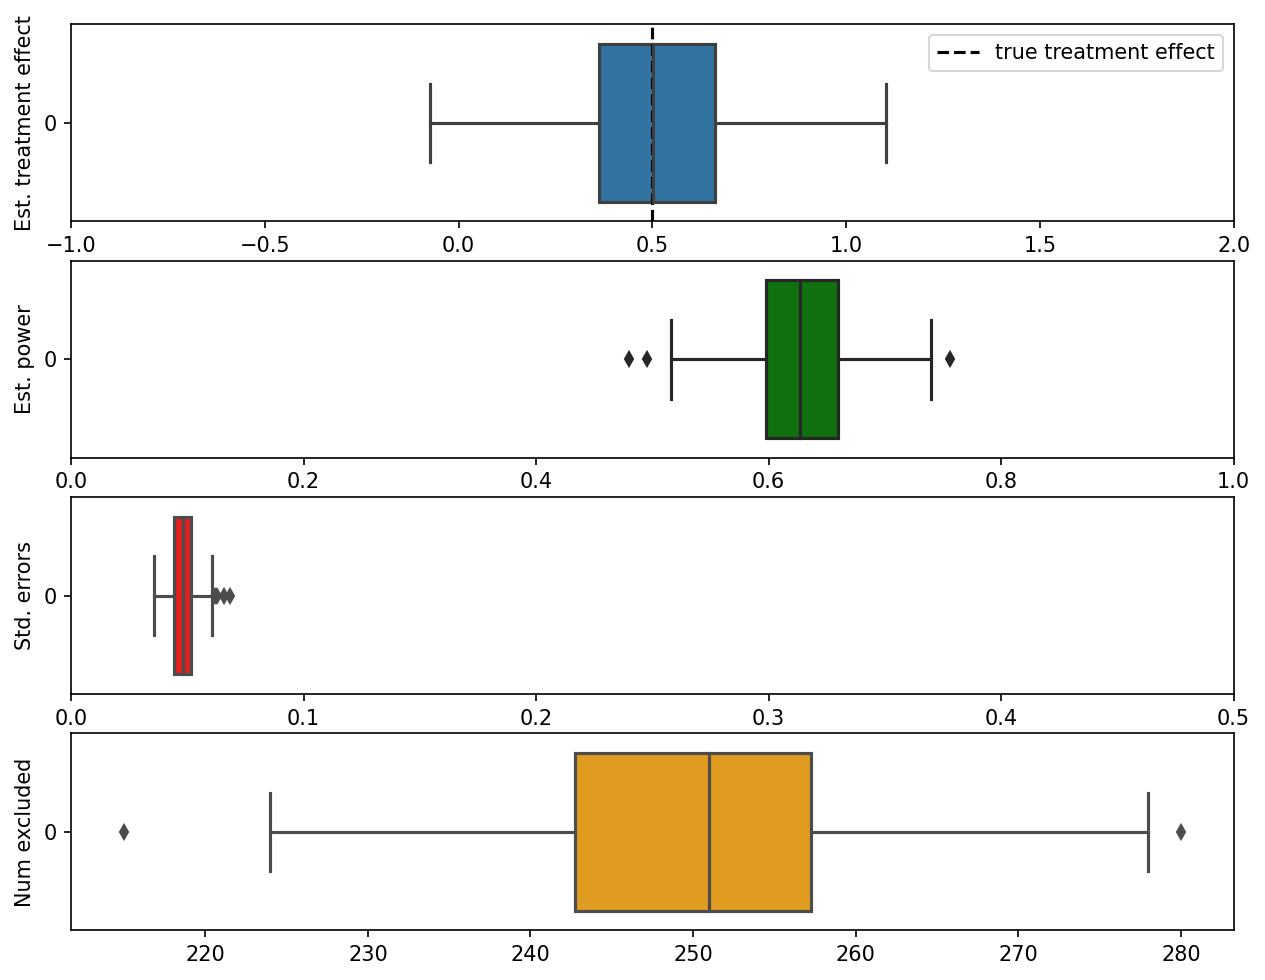

In [11]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "comply")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.7539449362171279
CPU times: user 1min 18s, sys: 1.98 s, total: 1min 20s
Wall time: 10 s


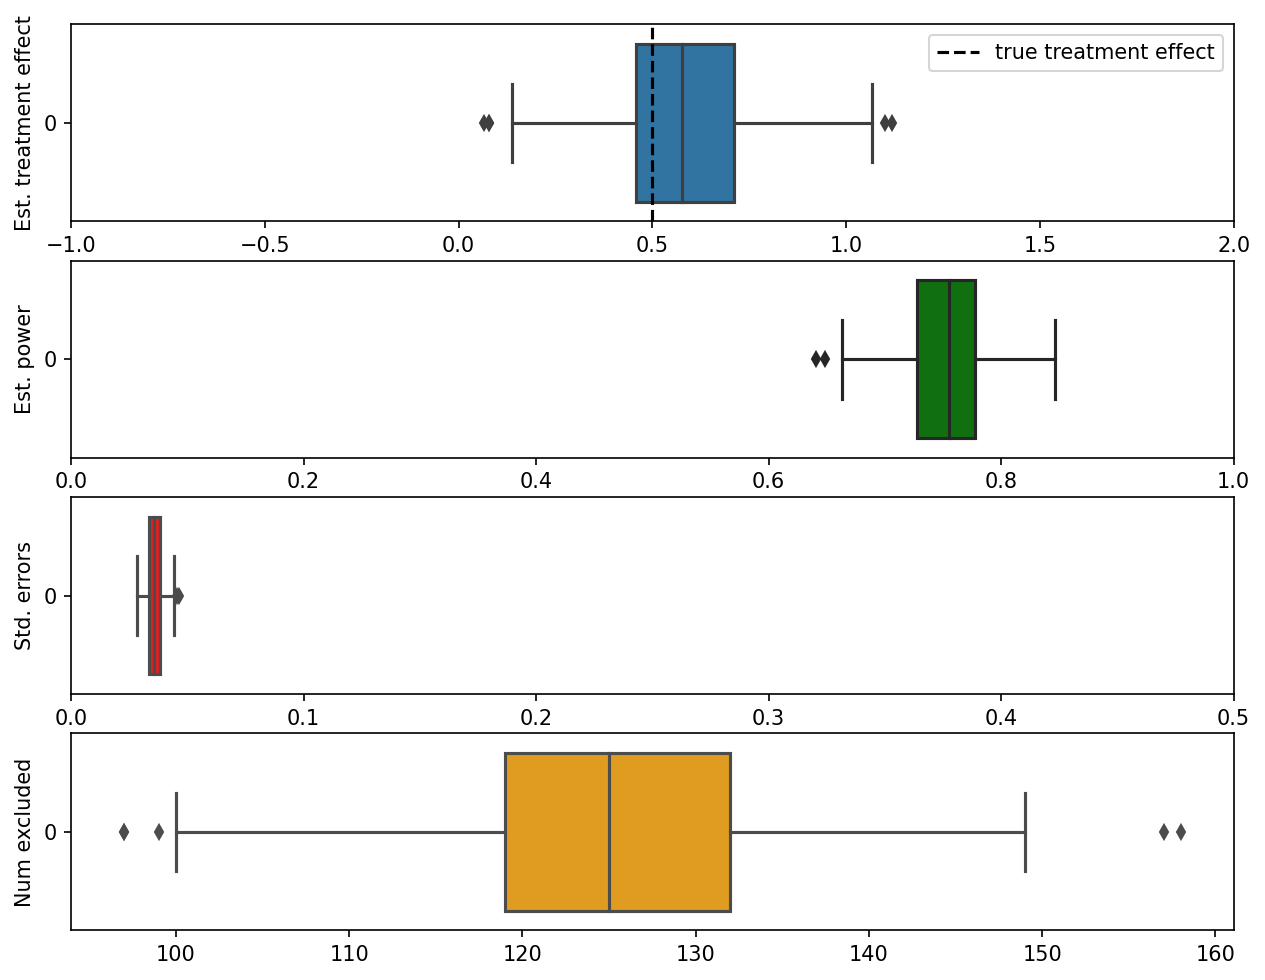

In [12]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "TneqZ")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.31950429222087096
CPU times: user 1min 14s, sys: 1.79 s, total: 1min 16s
Wall time: 9.56 s


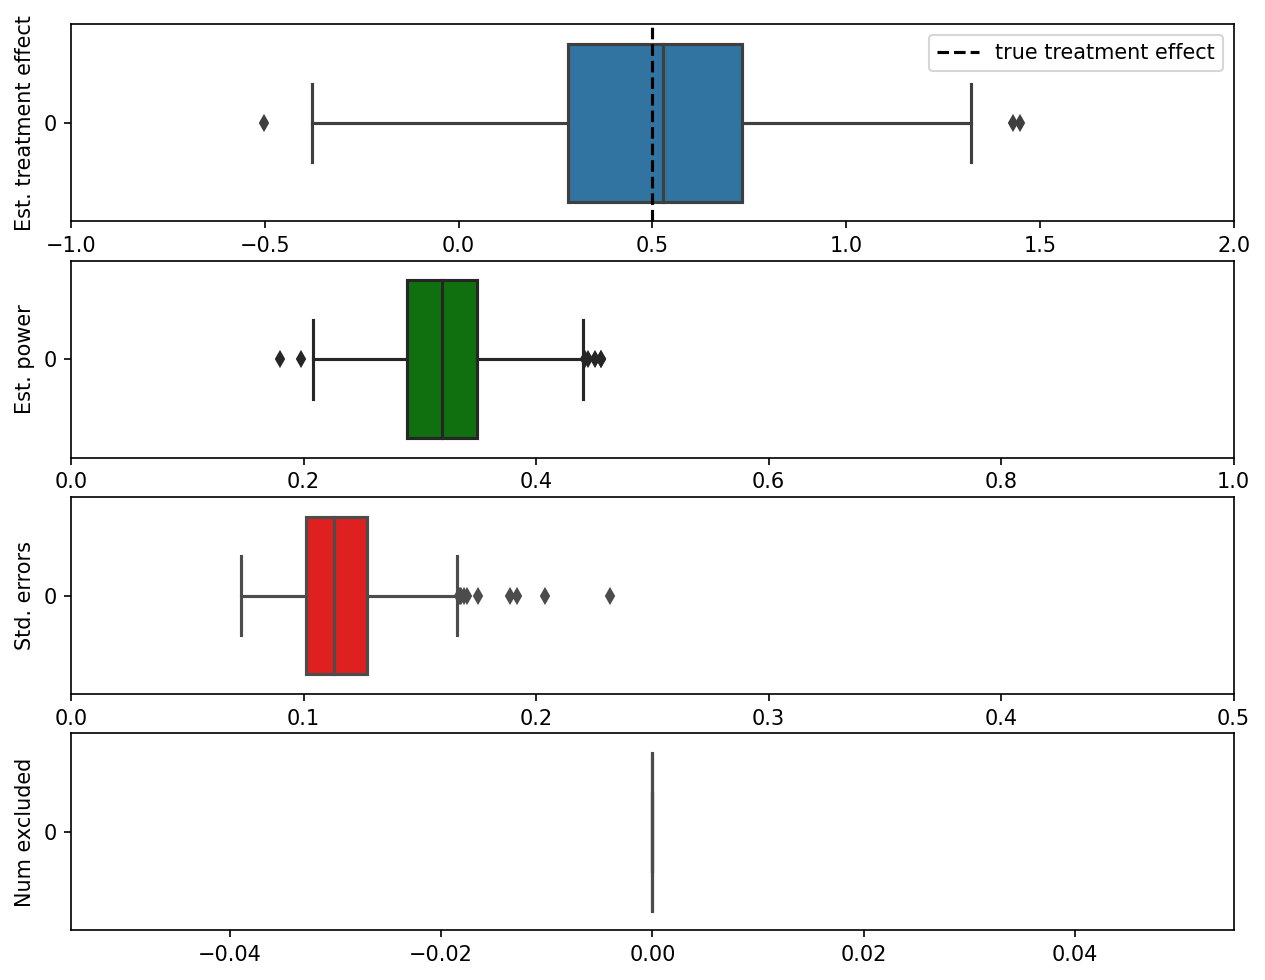

In [13]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, None)

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

# Power graphs as a function of compliance exclusion

- **note**: lifted from `naci_iv_walkthrough.ipynb` from old repo.

## Run simulation

In [14]:
%%time

n_samples = 1000
num_trials = 100
tau = 0.5

n_exclude = np.arange(0,901, 50)

exclude_list = []
complier_pwr_list = []
hat_pwr_list = []
var_list = []
target_effect_list = []
trial_list = []
comply_list = []
tau_list = []

compliances = [0.2, 0.4, 0.6]

formula = 'Y ~ 1+ [T ~ Z]'
for i in range(num_trials):
    print(i)
    for p_compliance in compliances:
        #df = gen_fuzzy_rdd_unif(n_samples, tau, p_compliance, seed=i)
        #df = df.sort_values('p_compliance', ascending=False)
        p_at = (1 - p_compliance) / 2
        p_nt = (1 - p_compliance) / 2
        
        df = generate_IV_comply_indicator(seed=i, 
                                       n_samples=n_samples, 
                                       tau=tau,
                                       prop_at=p_at,
                                       prop_nt=p_nt)
        #df['comply_order'] = df['comply_status'].apply(comply_to_int)
        
        #df = df.sort_values('comply_order', ascending=False)
        df = df.sort_values('X', ascending=False)
        for excl in n_exclude:
            trial_list.append(i)
            exclude_list.append(excl)
            comply_list.append(p_compliance)
            
            sel_df = df.head(int(n_samples-excl))
            ctl = sel_df[sel_df['T'] == 0]
            effect = np.std(ctl['Y']) / 2
            target_effect_list.append(effect)
            
            iv_model = IV2SLS.from_formula(formula, sel_df)
            iv_results = iv_model.fit(cov_type='robust')
            var = iv_results.std_errors['T']**2
            tau_hat = iv_results.params['T']
            var_list.append(var)
            tau_list.append(tau_hat)
            
            pwr = rdd_power(tau, var)
            #pwr = iv_power(sel_df, tau)
            complier_pwr_list.append(pwr)
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in matmul


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 10min 56s, sys: 18.7 s, total: 11min 15s
Wall time: 1min 24s


## Plot power curves

In [15]:
pwr_unif_df = pd.DataFrame()
pwr_unif_df['n_exclude'] = exclude_list
pwr_unif_df['trial'] = trial_list
pwr_unif_df['complier_pwr'] = complier_pwr_list
pwr_unif_df['frac_comply'] = comply_list
pwr_unif_df['fraction compliers'] = pwr_unif_df['frac_comply'] 

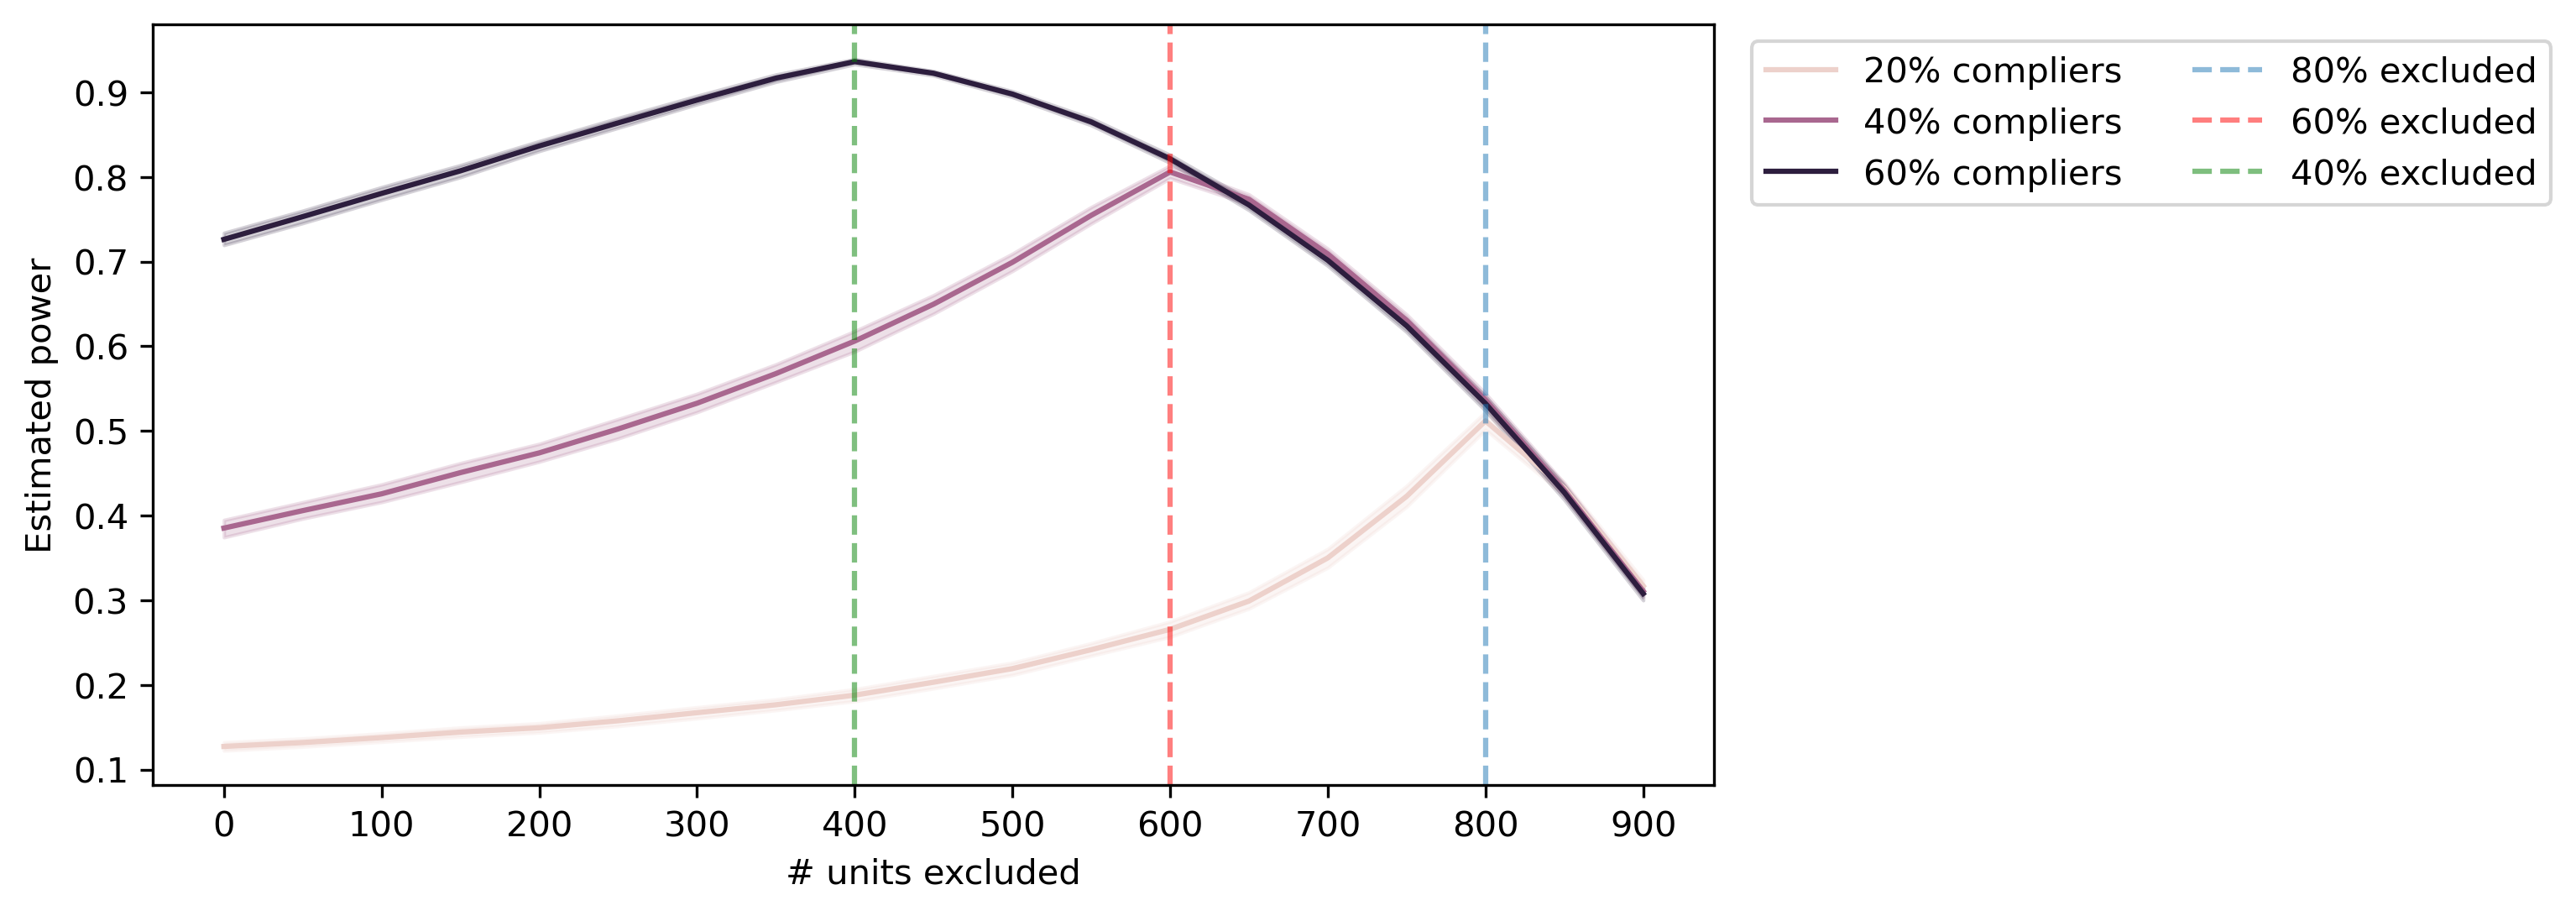

In [24]:
sns.lineplot(x='n_exclude', y='complier_pwr', data=pwr_unif_df, hue='fraction compliers', legend='full')
plt.axvline(x=800, label="80% excluded", ls='--', alpha=0.5)
plt.axvline(x=600, label="60% excluded", ls='--', color="r", alpha=0.5)
plt.axvline(x=400, label="40% excluded", ls='--', color='g', alpha=0.5)

plt.xticks(np.arange(0,1000,100))
legend = plt.legend(loc="center", ncol=2, bbox_to_anchor=(1.28, 0.87))
legend.get_texts()[0].set_text('20% compliers')
legend.get_texts()[1].set_text('40% compliers')
legend.get_texts()[2].set_text('60% compliers')
plt.ylabel("Estimated power")
plt.xlabel("# units excluded")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 4)

plt.savefig("../figures/pwr_known_comply.png", bbox_inches='tight')